# **GIS × Python Tutorial Session 8 ~ 点群データからオルソ画像を作成 ~**
---
この記事は「GIS × Python Tutorial」の関連記事です。

<br><br><br>

## **はじめに**
---
前回の記事では CSF（Cloth Simulation Filter） による点群分類と DTM（Digital Terrain Model） の作成を行いました。今回は DTM の後処理を行う予定でしたが、結構長くなりそうだったので、今回は点群データからオルソ画像を作成する方法について解説していきます。

 - オルソ画像とは
 
 - PDALで点群データからオルソ画像を生成する

 - rasterio

 - rasterioでのデータ読み込み

 - バンド合成

 - 様々なバンドの組み合わせ

 - rasterioでのデータ出力





## **今回使用するデータ**
---
今回は Session6 の記事で作成した '.las' を使用します。元々はオープンナガサキからダウンロードした点群データです。
<br><br><br>

<br><br><br>
## **インポート**
---

In [29]:
import json

from IPython.display import Image
import japanize_matplotlib
import geopandas as gpd
from matplotlib import pyplot as plt
from matplotlib.spines import Spine
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pdal
import pyproj
import rasterio
import rasterio.mask
import rasterio.plot
import shapely
from shapely.plotting import plot_polygon
japanize_matplotlib.japanize()


IN_FILE = r'../datasets/01ID7913_proj.las'
# 静岡県のEPSGコード
IN_EPSG = 'EPSG:6669'
proj_crs = pyproj.CRS(IN_EPSG)
IN_SRS = proj_crs.to_wkt(pretty=True)

## **オルソ画像とは**
---
**オルソ画像** とは上空から撮影した画像を正射変換し、真上から見たような傾きの無い、正しい大きさと位置に表示される様に変換した画像の事です。

上空の遠く離れた場所から大きな範囲を撮影した画像は、画像の端に行くほどに、写真に映る物体が大きく斜めに傾いて映っています。

オルソ画像を作成する場合の撮影は、以下の①の様に一意な範囲を撮影するのではなく、②の様に同じ場所が複数の写真に映るように撮影します。その画像を合成する事でオルソ画像を作成します。

進行方向に重なっている範囲を'オーバーラップ率'、折り返しなどで別なコースの写真と重なっている範囲を'サイドラップ率'と呼びます。

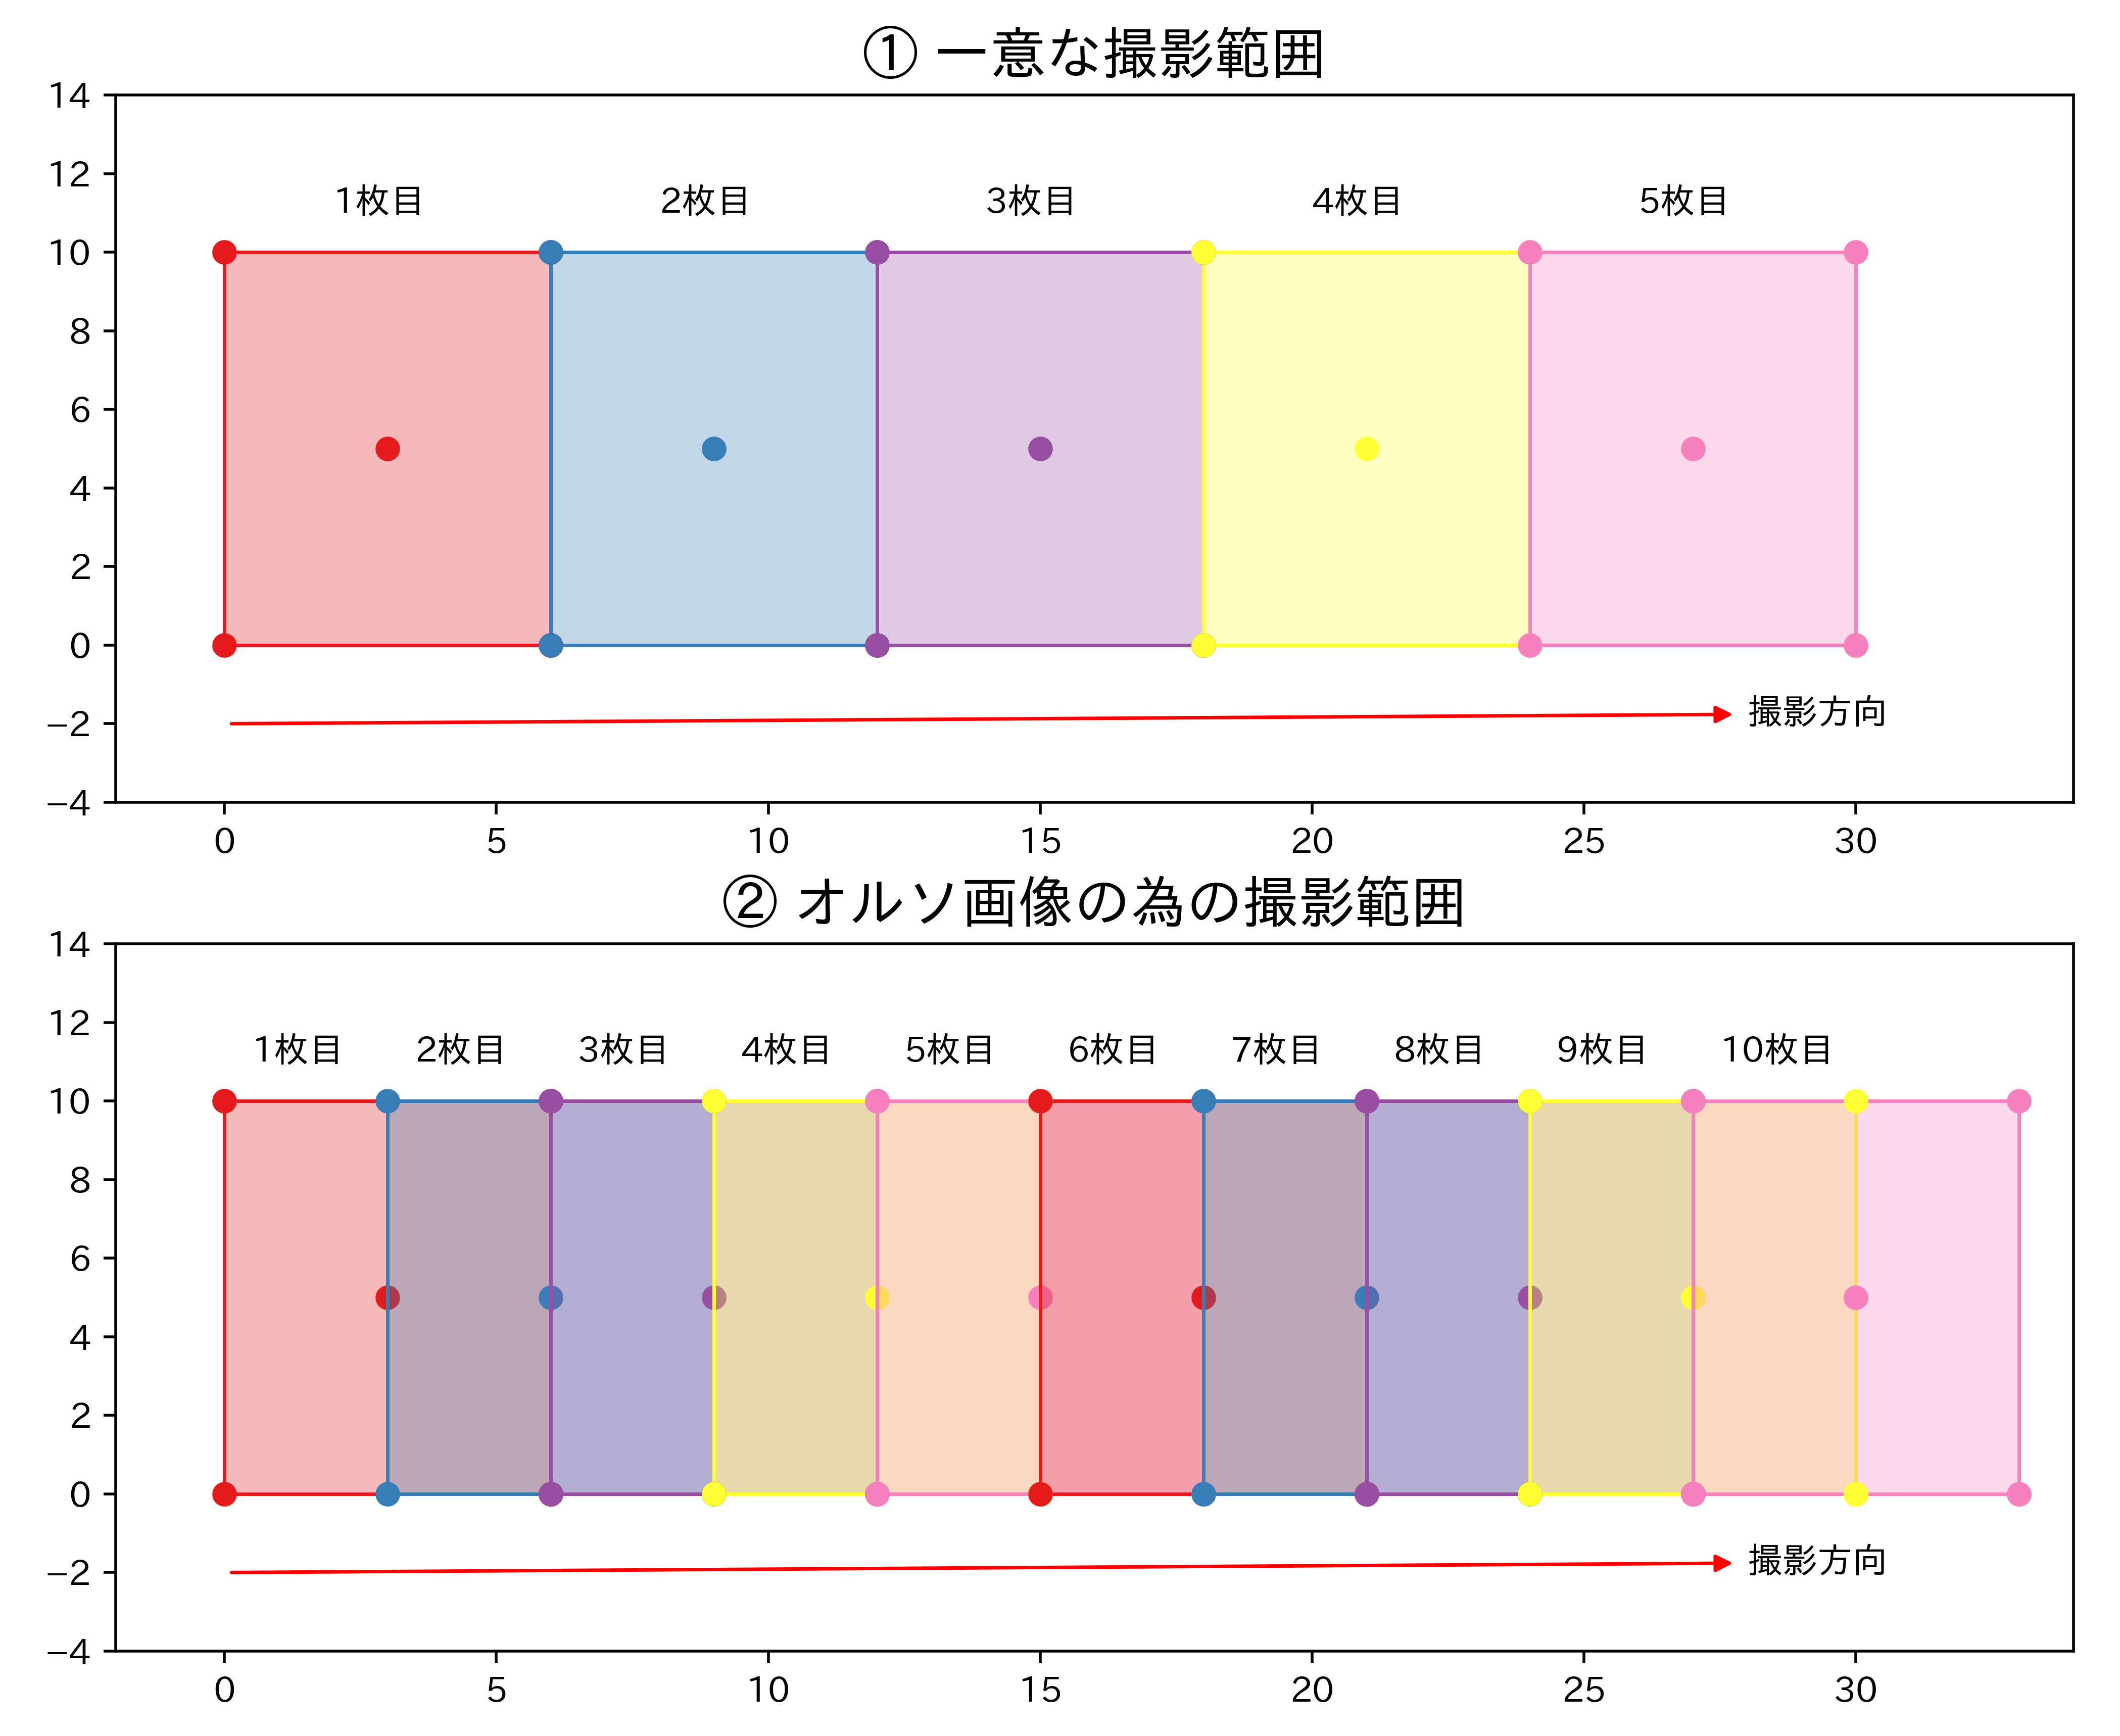

In [2]:

Image(r'../images/image_of_photographing.png', width=800)

In [3]:

Image(url='https://upload.wikimedia.org/wikipedia/commons/7/7b/%E5%9B%BD%E5%9C%9F%E5%9C%B0%E7%90%86%E9%99%A2_%E3%82%AA%E3%83%AB%E3%82%BD%E7%94%BB%E5%83%8F.jpg', width=800)

[出典：国土地理院ウェブサイト](https://www.gsi.go.jp/gazochosa/gazochosa40002.html)

## **PDAL で点群データからオルソ画像を作成する**
---
PDAL で点群データからトゥルーオルソ画像を作成するのは非常に簡単です。但しこれは点群データに RGB の情報が入力されている場合に限ります。

以前の記事でも見ましたが、まずは「点群データ（.las）にどんな情報が入力されているのか」を確かめてみましょう。

以前の記事では、Dict の中に Pipeline の処理を書いて、JSON 文字列化して処理を実行しました。今回は別な書き方をしてみます。オブジェクト指向に慣れた方であれば、こちらの方が分かりやすいかもしれません。

### **有用な要素の確認**
点群データの中から使用できそうな要素を確認します。要素の種類自体は多くありますが、実際に使用可能な要素は多くありません。pandas.DataFrame の形に変換し、不要な列を削除します。

In [33]:
readers = pdal.Reader.las(r'../datasets/01ID7913_sample.las')
pipeline = readers.pipeline()
pipeline.execute()
df = pipeline.get_dataframe(0)


del_cols = []
for col in df.columns:
    if len(df[col].unique()) == 1:
        del_cols.append(col)

df.drop(del_cols, axis=1).describe()

X              Y              Z      Intensity  \
count  308900.000000  308900.000000  308900.000000  308900.000000   
mean    -3179.391835   38199.401126     266.525639     153.281528   
std        98.292681      28.744838      10.704788      55.037304   
min     -3350.000000   38150.000000     222.600000       0.000000   
25%     -3261.990000   38174.577500     259.020000     120.000000   
50%     -3179.950000   38199.200000     264.440000     160.000000   
75%     -3099.750000   38223.910000     275.400000     194.000000   
max     -3000.000000   38250.000000     292.630000     255.000000   

                 Red          Green           Blue  
count  308900.000000  308900.000000  308900.000000  
mean    28015.023386   30660.133279   29424.474950  
std     10537.873062    8348.737934    7385.626974  
min      4883.000000   12593.000000   12593.000000  
25%     19018.000000   23644.000000   23130.000000  
50%     28270.000000   30840.000000   28784.000000  
75%     36494.000000   37522.000000   35466.000000  
max     65535.000000   65535.000000   65535.000000

画像の作成に使用出来そうな値は、**「Intensity（反射強度）」「Red」「Green」「Blue」** の4種類ですね。

### **地上解像度の設定をどうするか**

まずはパラメーターを設定します。地上解像度は単純にセルの大きさの事です。このセルの範囲に含まれる点群の要素を計算して、画像を作成するのでこの大きさを考えるのは重要なタスクです。1平方メートルあたり、何点計測されているのかを見てみましょう。

In [34]:
# メタデータから、計測範囲の座標を取り出す
metadata = pipeline.metadata.get('metadata').get('readers.las')
x_max, y_max = metadata.get('maxx'), metadata.get('maxy')
x_min, y_min = metadata.get('minx'), metadata.get('miny')

次に指定した範囲のグリッドデータを生成する関数を作成します。この関数では4隅の座標と地上解像度を指定することでグリッドを生成します。

In [35]:
def mesh_grid(x_min, y_min, x_max, y_max, resolution) -> list:
    # GridになるPolygonを格納したListを作成する
    polys = []
    for x in np.arange(x_min, x_max, resolution):
        for y in np.arange(y_min, y_max, resolution):
            poly = (
                shapely
                .Polygon([
                    [x, y],
                    [x + resolution, y],
                    [x + resolution, y + resolution],
                    [x, y + resolution],
                ])
            )
            polys.append(poly)
    return polys

国土地理院の公開している「UAV搭載型レーザースキャナを用いた公共測量マニュアル（案）」では以下の様に書かれています。

`準則の航空レーザ測量では、グリッドデータを作成する際に、点群が取得できない格子の割合を欠測率として定めている。準則第４３５条では『欠測率＝(欠測格子数／格子数）×100)』と定め、格子間隔が1mを超えるグリッドデータを作成する場合の欠測率は10％以下、1m以下の場合は15％以下を標準としている。`

今回作成するデータはRGB画像ですが、欠損率を調べてみましょう。

Gridを Geometryにセットした GeoDataFrameと、点群データを Geometryにセットした GeoDataFrameの 2つを作成します。Grid側をメインに点群側のデータを `sjoin` メソッドで空間結合し、その後 `groupby` メソッドで集計処理を行い、欠損率を調べます。


In [128]:
# 地上解像度
RESOLUTION = 1.0

# Gridを格納したGeoDataFrameを作成する
material = [x_min, y_min, x_max, y_max, RESOLUTION]
grid_gr1 = mesh_grid(*material)

grid_gr1.append(shapely.Polygon([(0, 0), (0, 10), (10, 10), (10, 0)]))
gdf_gr1 = gpd.GeoDataFrame(
    data={'idx': list(range(len(grid_gr1)))}, 
    geometry=grid_gr1
)

# 点群データを格納したGeoDataFrameを作成する
point_cloud = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df['X'], df['Y']))

# 空間結合。howに leftを指定しないと、欠損している Gridが消えてしまうので注意
jd_grid_gr1 = gpd.sjoin(gdf_gr1, point_cloud, how='left')
jd_grid_gr1.head(3)

idx                                           geometry  index_right
0    0  POLYGON ((-3350.000 38150.000, -3349.000 38150...      33542.0
0    0  POLYGON ((-3350.000 38150.000, -3349.000 38150...       8802.0
0    0  POLYGON ((-3350.000 38150.000, -3349.000 38150...      35951.0

In [129]:
# 見づらいので列名を変更
jd_grid_gr1 = jd_grid_gr1.rename(columns={'index_right': 'count'})

# 集計処理の為に欠損 Grid以外に 1を入力する
func = lambda x:0 if np.isnan(x) else 1
jd_grid_gr1['count'] = jd_grid_gr1['count'].apply(func)

# 集計処理
agged = jd_grid_gr1.groupby(by='idx').agg({'geometry': 'first', 'count': 'sum'})

<Axes: >

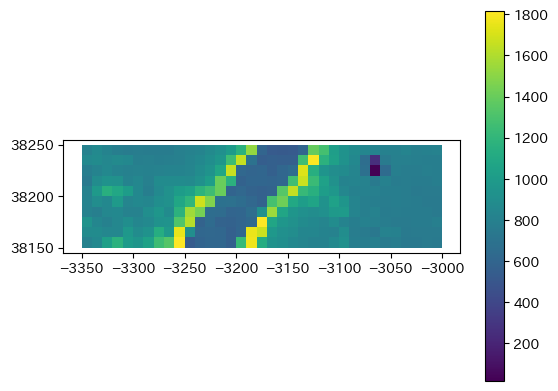

In [97]:
agged.plot(column='index_right', cmap='viridis', legend=True)

<Axes: >

(-3350.5, -3339.5, 38148.5, 38181.5)

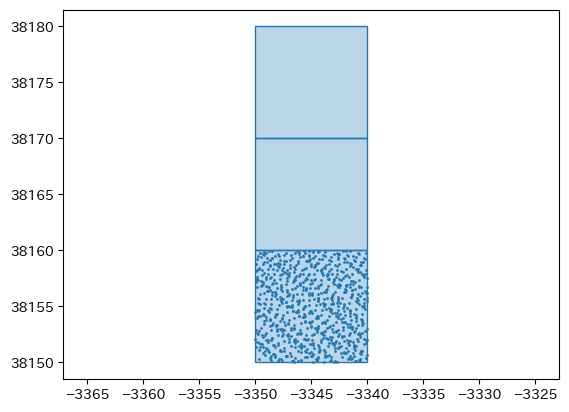

In [83]:

fig, ax = plt.subplots()

for poly in gdf_gr1.geometry[: 3]:
    plot_polygon(poly, ax=ax, add_points=False)

ax.scatter(pts.x, pts.y, s=1)

plt.axis('equal')

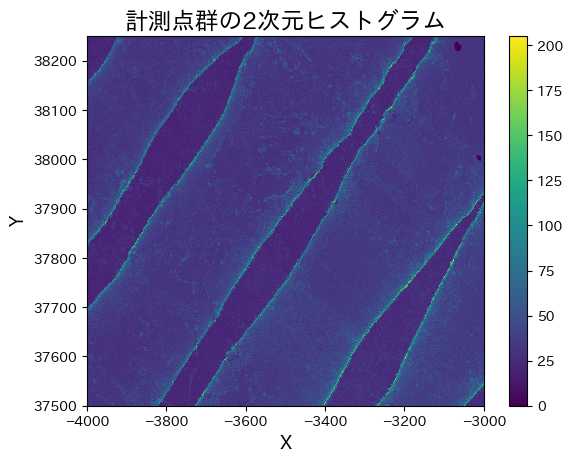

In [6]:
# セル数を適当に決める
bins = [int(v / 2) for v in (x_max - (x_min), y_max - (y_min))]

plt.hist2d(df['X'], df['Y'], bins=bins)
plt.colorbar()
plt.title('計測点群の2次元ヒストグラム', fontsize=17)
plt.xlabel('X', fontsize=13)
plt.ylabel('Y', fontsize=13);

正直2次元ヒストグラムではよくわかりませんが、平均1㎡あたり9点なので地上解像度を 0.5m 程度に設定して見ましょう。

### **各パラメーターの設定**

Intensity は最大値が 255 なので 8bit ですが、「Red」「Green」「Blue」 の方は最大値が2の16乗の範囲内なので、16bit だと推測できます。別にこのまま出力してもいいですが、使いやすいように 8bit の範囲に変換してしまいましょう。

In [50]:
# 出力ファイルのパスを設定
INTENSITY_PATH = IN_FILE.replace('proj.las', 'INTENSITY.tif')
RED_PATH = IN_FILE.replace('proj.las', 'RED.tif')
GREEN_PATH = IN_FILE.replace('proj.las', 'GREEN.tif')
BLUE_PATH = IN_FILE.replace('proj.las', 'BLUE.tif')
ORTHO_PATH = IN_FILE.replace('proj.las', 'TRUE_ORTHO.tif')

# 地上解像度の設定
RESOLUTION = 0.5

# 16bit の最大値を設定する
_16bit = 2**16 - 1

# 画像として出力する際の設定
write_dict = {
    'type': 'writers.gdal',
    'data_type': 'uint8',
    'resolution': RESOLUTION,
    'output_type': 'mean',
    'nodata': 0,
    'default_srs': IN_SRS,
    'gdaldriver': 'GTiff'
}

### **Pipelineの作成と実行**

In [9]:
# データの読み込み
readers = readers = pdal.Reader.las(IN_FILE)

# 16bit から 8bit への変換するタスクを構成
fassign = (
    pdal
    .Filter
    .assign(
        value=[
            f'Red = Red / {_16bit} * 255',
            f'Green = Green / {_16bit} * 255',
            f'Blue = Blue / {_16bit} * 255',
        ]
    )
)

paths = [INTENSITY_PATH, RED_PATH, GREEN_PATH, BLUE_PATH]
cols = ['Intensity', 'Red', 'Green', 'Blue']
for path, col in zip(paths, cols):
    # データを書き込むタスクを構成
    writers = (
        pdal
        .Writer(
            filename=path, 
            dimension=col, 
            **write_dict
        )
    )
    # Pipelineの作成と実行
    pipeline = readers | fassign | writers
    pipeline.execute()


これで各要素を Raster （画像）として出力する事が出来ました。

## **rasterio**
---
次は出力した Raster を読み込んで確認してみましょう。Raster の入出力や加工には `rasterio` というライブラリーを使用します。`GDAL` の方が有名かもしれませんが、python で扱うのであれば rasterio の方が簡単で、ドキュメントも読みやすいので、おススメです。

### **rasterioでのデータ入力**
まずは先ほど出力した 4枚の画像を読み込みます。

In [8]:
intensity_dst = rasterio.open(INTENSITY_PATH)

red_dst = rasterio.open(RED_PATH)

green_dst = rasterio.open(GREEN_PATH)

blue_dst = rasterio.open(BLUE_PATH)

### **RGB配列の作成**
読み込んだデータから、配列を取り出す為には`read`メソッドを使用します。RGB 画像は Red と Green 、Blue の3つのデータを使用するので、各データから配列を取り出して重ねてみます。

In [9]:
raster = np.array([
    red_dst.read(1),
    green_dst.read(1),
    blue_dst.read(1),
])

print(raster.shape)

(3, 1501, 2001)


上記で配列の形状を確認しましたが、この状態では matplotlib で表示する事が出来ません。`numpy.dstack` を使用して、配列の形状を変更しましょう。

In [10]:
img = np.dstack(raster)

print(img.shape)

(1501, 2001, 3)


### **画像の確認**
それでは上記で作成した RGB と Intensity のデータを matplotlib で表示してみます。

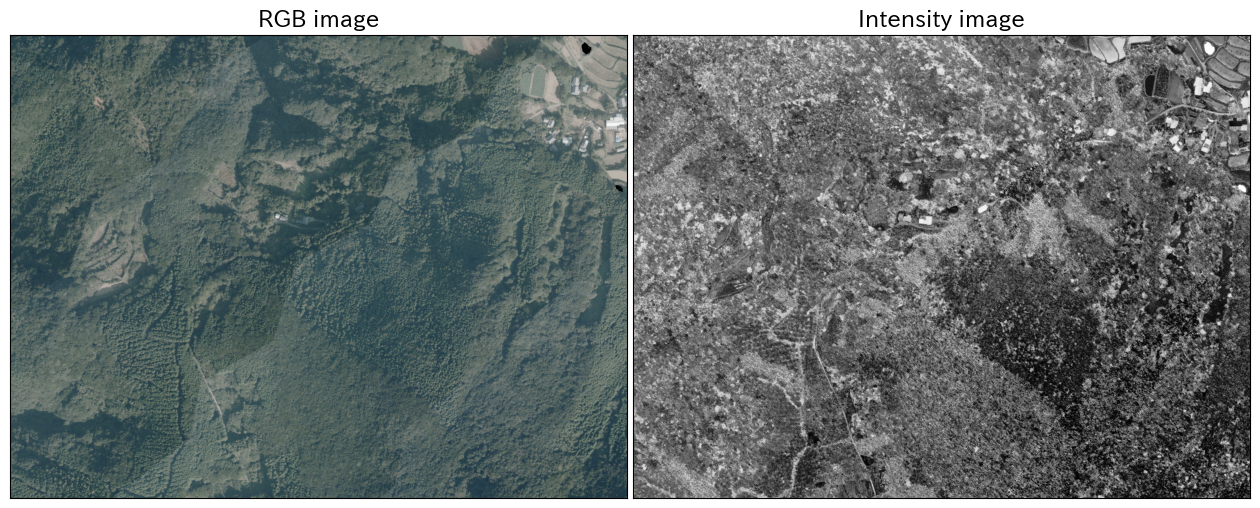

In [11]:
arys = [img, intensity_dst.read(1)]
titles = ['RGB image', 'Intensity image']

fig, ax = plt.subplots(ncols=2, figsize=(16, 10))
for _ax, ary, title in zip(ax, arys, titles):
    _ax.set_title(title, fontsize=17)
    _ax.imshow(ary, cmap='Grays')
    _ax.axes.xaxis.set_visible(False)
    _ax.axes.yaxis.set_visible(False)

plt.subplots_adjust(wspace=0.01);

## **Rasterの出力**
---
一旦 RGB のオルソ画像を出力します。GISのアプリなどで使用する場合は普通に '.tif' のフォーマットで出力すると思いますが、Notebookなどで使用する場合は


In [76]:
metadata = intensity_dst.meta
metadata['count'] = 3
with rasterio.open(ORTHO_PATH, mode='w', **metadata) as dst:
    for i, _dst in enumerate([red_dst, green_dst, blue_dst]):
        dst.write(_dst.read(1), i + 1)

In [77]:
ortho_dst = rasterio.open(ORTHO_PATH)

## **Intensity を見てみる**
---

少し Intensity を詳しく見てみましょう。Intensity（反射強度）とは、ポイントを生成しているレーザーパルスが反射される強さを計測し、集計したものです。この数値は「スキャン角度」「粗さ」「含水率」などによって異なります。

調べてみると、反射強度の数値は絶対的な数値ではなく、相対的な数値の様です。その為、同じ場所を計測した場合であっても異なる数値が集計され、正規化された数値を記録している場合がある様です。

引用元:

[ArcGIS での LIDAR からの強度画像の作成](https://desktop.arcgis.com/ja/arcmap/latest/manage-data/las-dataset/lidar-solutions-creating-intensity-images-from-lidar.htm)

[LIDAR INTENSITY: WHAT IS IT AND WHAT ARE IT’S APPLICATIONS?](https://geodetics.com/lidar-intensity-applications/)

In [12]:


# ints_scope_1 = rasterio.mask.mask(intensity_ds, shapes=[poly_mask], crop=True)

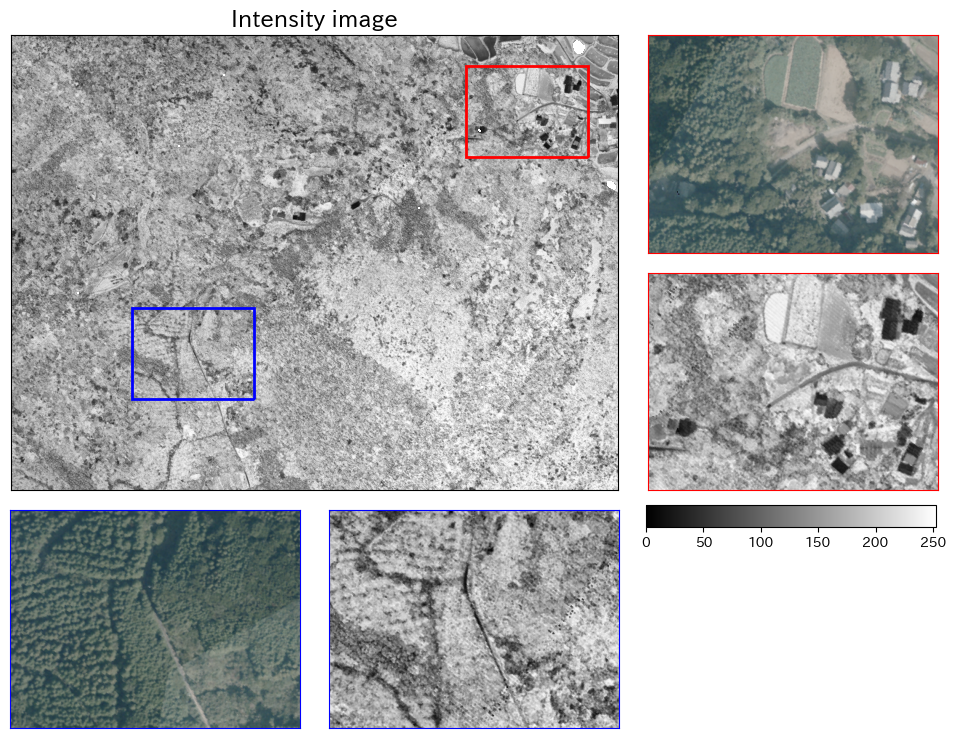

In [126]:
scope_1 = shapely.box(-3250, 38050, -3050, 38200)
scope_2 = shapely.box(-3800, 37650, -3600, 37800)

# 長く読みづらいですが、下記のコードで可視化します。
intensity = intensity_dst.read(1)

fig = plt.figure(figsize=(12, 9))
shape = (6, 6)
# Axis 1
ax1 = plt.subplot2grid(shape, loc=(0, 0), colspan=4, rowspan=4)
ax1.set_title('Intensity image', fontsize=17)
rasterio.plot.show(intensity_dst, cmap='binary_r', ax=ax1)
kwargs = dict(facecolor=(0, 0, 0, 0), linewidth=2, add_points=False)
plot_polygon(scope_1, color='red', **kwargs)
plot_polygon(scope_2, color='blue', **kwargs)

# Axis 2
spans = dict(colspan=2, rowspan=2)
right_kwargs = dict(shapes=[scope_1], crop=True)
ax2 = plt.subplot2grid(shape, loc=(0, 4), **spans)
ax2_img = rasterio.mask.mask(ortho_dst, **right_kwargs)
ax2.imshow(np.dstack(ax2_img[0]))

# Axis 3
ax3 = plt.subplot2grid(shape, loc=(2, 4), **spans)
ax3_img = rasterio.mask.mask(intensity_dst, **right_kwargs)
cb = ax3.imshow(ax3_img[0][0], cmap='binary_r')

# Axis 4
bottom_kwargs = dict(shapes=[scope_2], crop=True)
ax4 = plt.subplot2grid(shape, loc=(4, 0), **spans)
ax4_img = rasterio.mask.mask(ortho_dst, **bottom_kwargs)
ax4.imshow(np.dstack(ax4_img[0]))

# Axis 5
ax5 = plt.subplot2grid(shape, loc=(4, 2), **spans)
ax5_img = rasterio.mask.mask(intensity_dst, **bottom_kwargs)
ax5.imshow(ax5_img[0][0], cmap='binary_r')

# Polygonに合わせてAxisのラインに色を付ける
for _ax, c in zip(fig.axes[1: ], ['red', 'red', 'blue', 'blue']):
    for children in _ax.get_children():
        if isinstance(children, Spine):
            children.set_color(c)

# メモリを消す
for _ax in fig.axes:
    _ax.axes.xaxis.set_visible(False)
    _ax.axes.yaxis.set_visible(False)
    _ax.grid(False)

# Colorbarの表示
cax = inset_axes(
    ax3, width='100%', height='10%', 
    bbox_to_anchor=(-0.03, -0.2, 1, 1),
    bbox_transform=ax3.transAxes, loc='lower left'
)
fig.colorbar(cb, cax=cax, orientation="horizontal");
plt.grid(False)

個人的なイメージとしては、屋根や道路の方が反射率が高いかと思っていましたが、上の図を見ると逆の様です。

## バンド合成で遊ぶ
---
普段よく目にする画像は RGB の画像ですが、各配列の順序を変更したり、

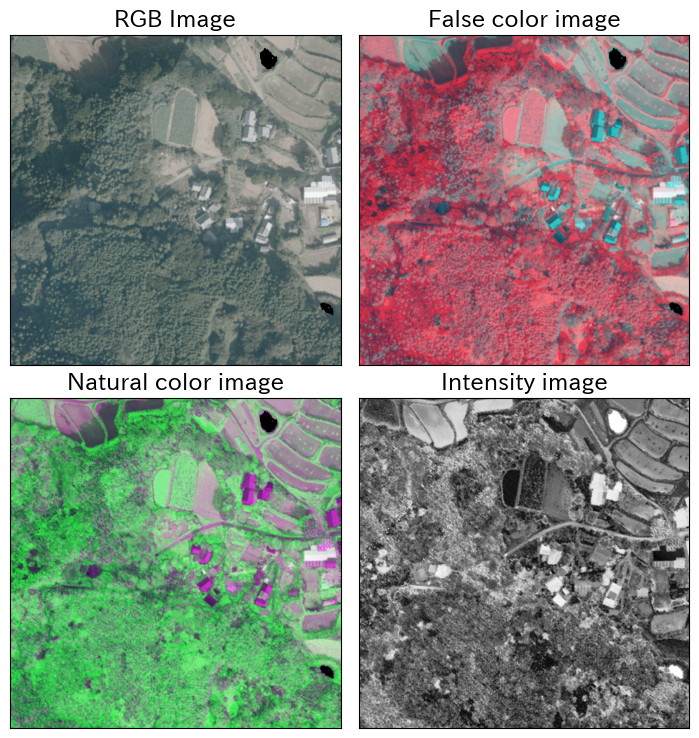

In [190]:

false_ary = np.dstack([
    intensity_dst.read(1),
    red_dst.read(1),
    green_dst.read(1)
])

natural_ary = np.dstack([
    red_dst.read(1),
    intensity_dst.read(1),
    green_dst.read(1)
])

invd_natural_ary = np.dstack([
    (np.array(intensity_dst.read(1).tolist()) - 255) * (-1),
    green_dst.read(1),
    (np.array(intensity_dst.read(1).tolist()) - 255) * (-1)
])

titles = [
    'RGB Image', 'False color image',
    'Natural color image', 'Intensity image'
]
arys = [
    img, false_ary,
    natural_ary, intensity_dst.read(1),
]


fig = plt.figure(figsize=(9, 9))
for i, (ary, title) in enumerate(zip(arys, titles)):
    ax = fig.add_subplot(2, 2, i + 1)
    ax.set_title(title, fontsize=17)
    ax.imshow(ary[: 600, 1400:], cmap='Grays')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

plt.subplots_adjust(wspace=0, hspace=0.1)